# 用 LSTM 做时间序列预测

> 参考链接
> 
> 用 LSTM 做时间序列预测的一个小例子
> <https://www.jianshu.com/p/38df71cad1f6>
>
> Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras
> <https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/>

问题：航班乘客预测
数据：1949 到 1960 一共 12 年，每年 12 个月的数据，一共 144 个数据，单位是 1000

下载地址<https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line>

目标：预测国际航班未来 1 个月的乘客数

In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

/Users/sunlu/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


导入数据

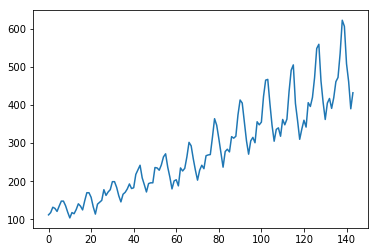

In [2]:
# load the dataset
dataframe = read_csv('international-airline-passengers.csv', usecols=[1], 
                     engine='python', skipfooter=3)
dataset = dataframe.values
# 将整型变为float
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

In [3]:
dataframe.head(5)

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


从这 12 年的数据可以看到上升的趋势，每一年内的 12 个月里又有周期性季节性的规律

需要把数据做一下转化:

将一列变成两列，第一列是 t 月的乘客数，第二列是 t+1 列的乘客数。
look_back 就是预测下一步所需要的 time steps：

timesteps 就是 LSTM 认为每个输入数据与前多少个陆续输入的数据有联系。例如具有这样用段序列数据 “…ABCDBCEDF…”，当 timesteps 为 3 时，在模型预测中如果输入数据为“D”，那么之前接收的数据如果为“B”和“C”则此时的预测输出为 B 的概率更大，之前接收的数据如果为“C”和“E”，则此时的预测输出为 F 的概率更大。


In [17]:
# X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)


当激活函数为 sigmoid 或者 tanh 时，要把数据正则话，此时 LSTM 比较敏感

设定 67% 是训练数据，余下的是测试数据

In [18]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


X=t and Y=t+1 时的数据，并且此时的维度为 [samples, features]

In [19]:
# use this function to prepare the train and test datasets for modeling
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [25]:
trainX[0,0]

0.0154440105

In [28]:
trainY[0]

0.027027026

In [29]:
len(train)

96

In [32]:
print trainX.shape
print trainY.shape

(94, 1, 1)
(94,)


投入到 LSTM 的 X 需要有这样的结构： [samples, time steps, features]，所以做一下变换

In [31]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


建立 LSTM 模型：
输入层有 1 个input，隐藏层有 4 个神经元，输出层就是预测一个值，激活函数用 sigmoid，迭代 100 次，batch size 为 1

In [12]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
 - 1s - loss: 0.0413
Epoch 2/100
 - 0s - loss: 0.0202
Epoch 3/100
 - 0s - loss: 0.0145
Epoch 4/100
 - 0s - loss: 0.0131
Epoch 5/100
 - 0s - loss: 0.0121
Epoch 6/100
 - 0s - loss: 0.0111
Epoch 7/100
 - 0s - loss: 0.0102
Epoch 8/100
 - 0s - loss: 0.0093
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0071
Epoch 11/100
 - 0s - loss: 0.0062
Epoch 12/100
 - 0s - loss: 0.0053
Epoch 13/100
 - 0s - loss: 0.0045
Epoch 14/100
 - 0s - loss: 0.0038
Epoch 15/100
 - 0s - loss: 0.0033
Epoch 16/100
 - 0s - loss: 0.0029
Epoch 17/100
 - 0s - loss: 0.0026
Epoch 18/100
 - 0s - loss: 0.0024
Epoch 19/100
 - 0s - loss: 0.0022
Epoch 20/100
 - 0s - loss: 0.0022
Epoch 21/100
 - 0s - loss: 0.0021
Epoch 22/100
 - 0s - loss: 0.0021
Epoch 23/100
 - 0s - loss: 0.0021
Epoch 24/100
 - 0s - loss: 0.0021
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0021
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 1s - loss: 0.0020
Epoch 30/100
 - 0s - lo

预测：

In [13]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

计算误差之前要先把预测数据转换成同一单位

In [14]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


计算 mean squared error

In [15]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 22.92 RMSE
Test Score: 47.53 RMSE


画出结果：蓝色为原数据，绿色为训练集的预测值，红色为测试集的预测值

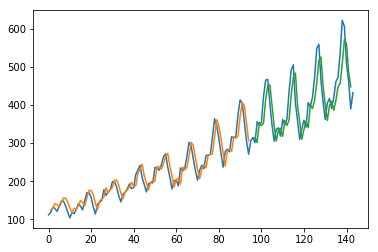

In [16]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
